<a href="https://colab.research.google.com/github/sarthak221995/100DaysOfMLCode/blob/master/CIFAR_100%7C_Batch_Size_32_%7C_Optimizer_RMSProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 | CIFAR 100 | Question 1

# Import Libraries/Dataset

## Import the required libraries and the dataset

In [47]:
import os
import numpy as np
import pickle
import h5py
import pandas as pd

from __future__ import print_function
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

In [48]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

## Check the GPU available

In [49]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Data Visualization and Augmentation

## Plot at least two samples from each class of the dataset

### Original Data

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


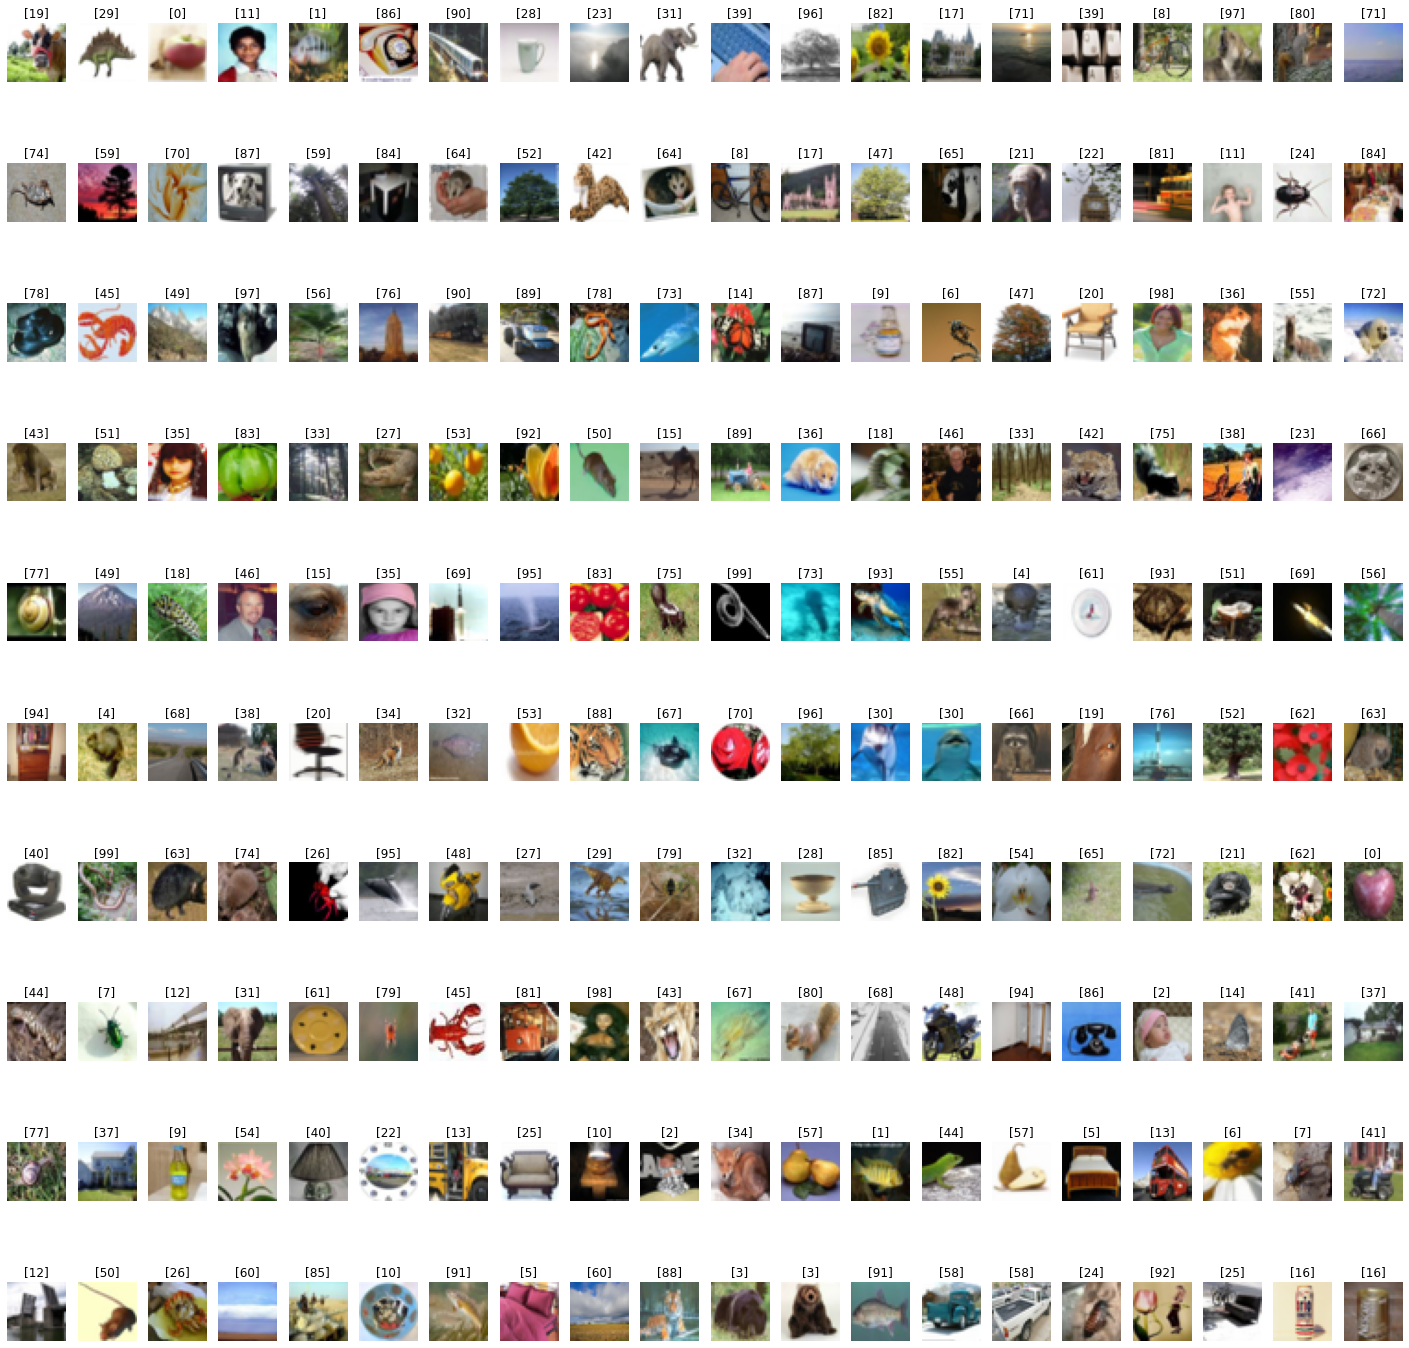

In [50]:
# Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).
temp = pd.DataFrame()
temp['label'] = list(y_train.flat)
sample_indexes_two_samples = temp.groupby('label').head(2).index.to_list()
sample_indexes_one_samples = temp.groupby('label').head(1).index.to_list()

W_grid = 20
L_grid = 10

fig,axis = plt.subplots(L_grid, W_grid,figsize = (25,25))
axis = axis.ravel()

for i,index in zip(np.arange(0, L_grid * W_grid),sample_indexes_two_samples):
    axis[i].imshow(x_train[index])
    axis[i].set_title(y_train[index])
    axis[i].axis('off')  
plt.subplots_adjust(hspace= 0.4)

## Apply horizontal flip and width shift augmentation

### Augmented Samples

#### Width Shift Range

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


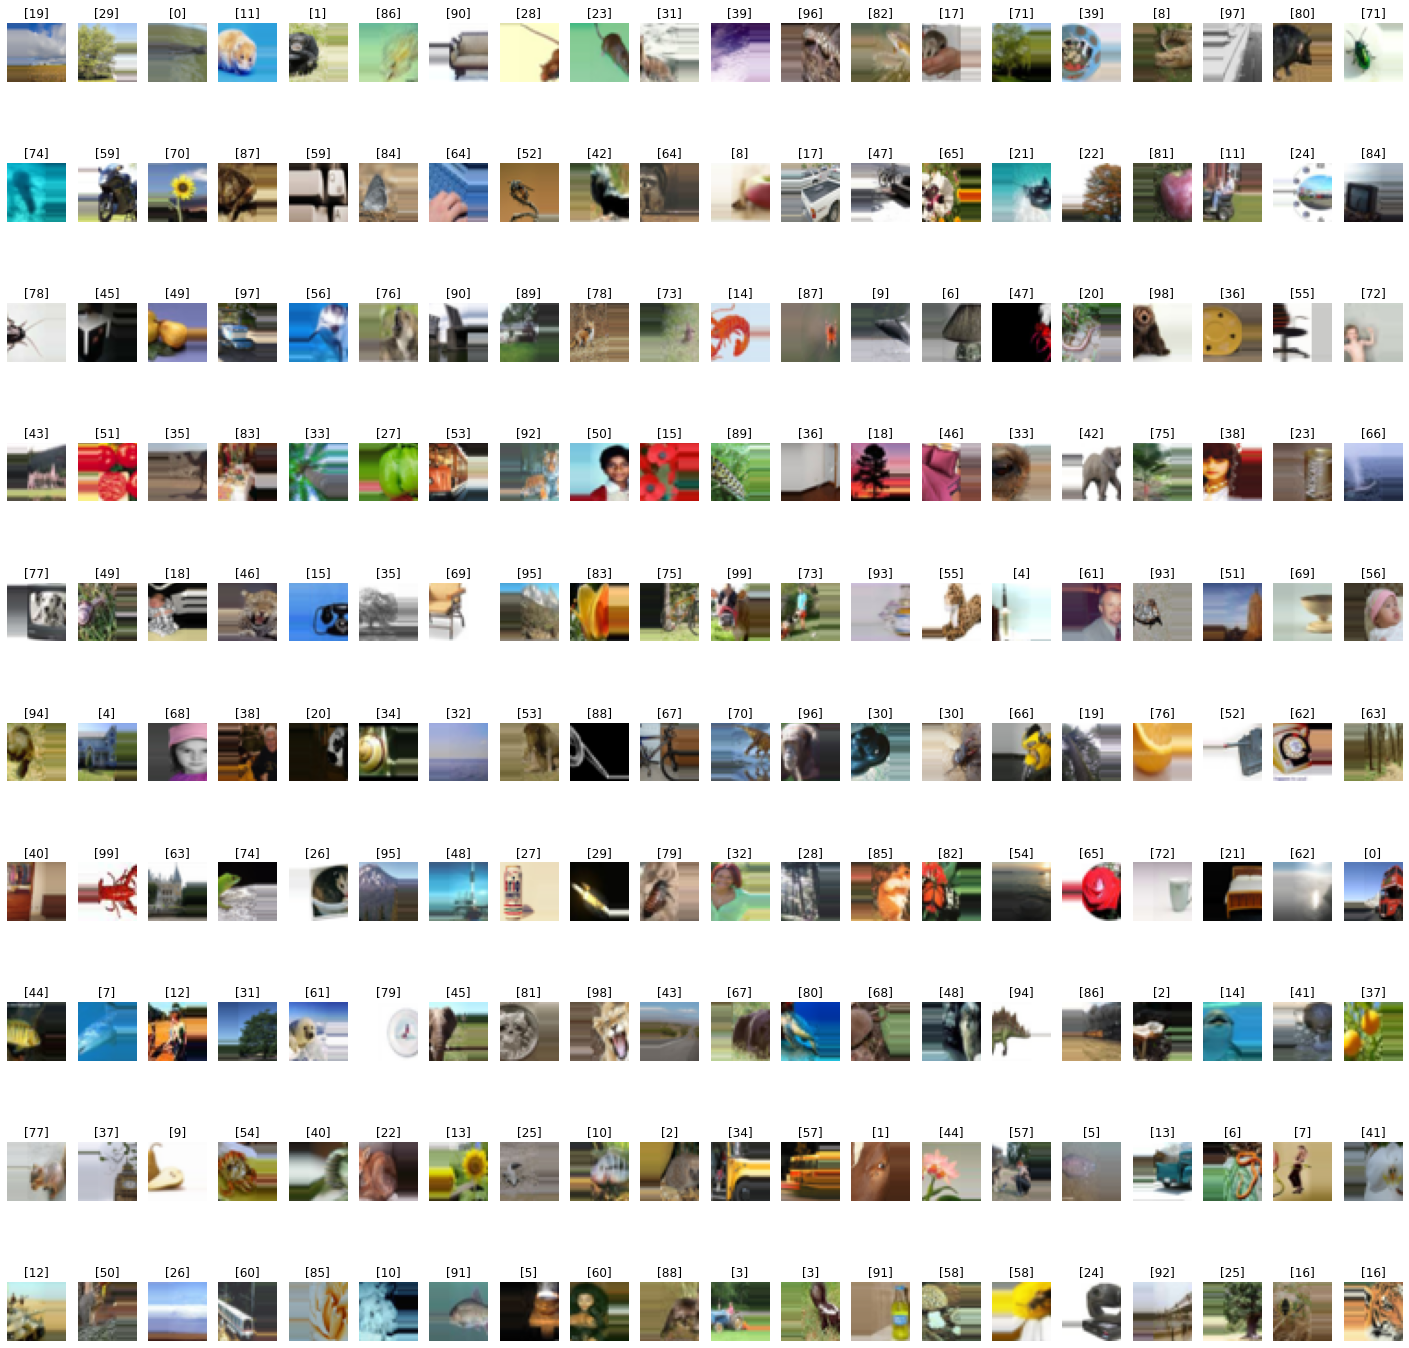

In [51]:
samples = x_train[sample_indexes_two_samples]
width_shift_range_aug_gen = ImageDataGenerator(width_shift_range=[-10,10])
width_shift_range_aug_gen_flow = width_shift_range_aug_gen.flow(samples, batch_size=1)

W_grid = 20
L_grid = 10

fig,axis = plt.subplots(L_grid, W_grid,figsize = (25,25))
axis = axis.ravel()

for i,index in zip(np.arange(0, L_grid * W_grid),sample_indexes_two_samples):
    batch = width_shift_range_aug_gen_flow.next()
    image = batch[0].astype('uint8')
    axis[i].imshow(image)
    axis[i].set_title(y_train[index])
    axis[i].axis('off')  
plt.subplots_adjust(hspace= 0.4)

#### Horizontal Flip

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


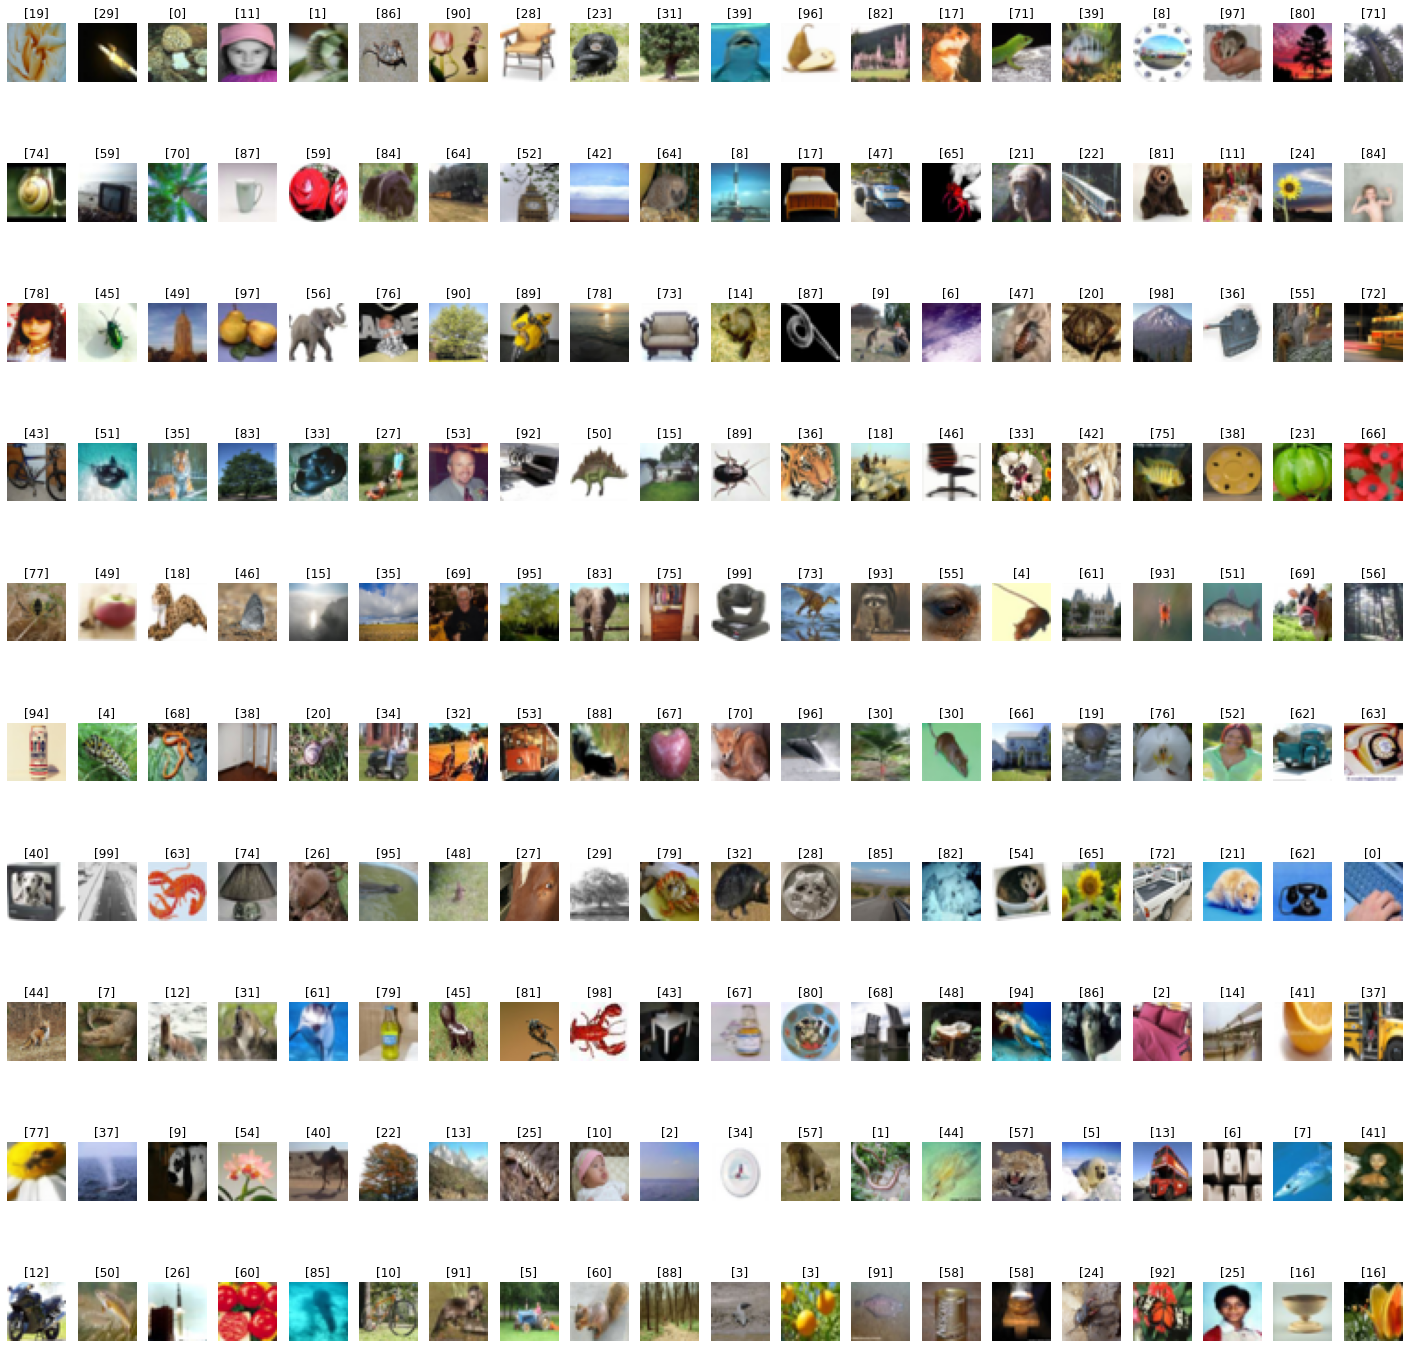

In [52]:
horizontal_flip_aug_gen = ImageDataGenerator(ImageDataGenerator(horizontal_flip=True))
horizontal_flip_aug_gen_flow = horizontal_flip_aug_gen.flow(samples, batch_size=1)

W_grid = 20
L_grid = 10

fig,axis = plt.subplots(L_grid, W_grid,figsize = (25,25))
axis = axis.ravel()

for i,index in zip(np.arange(0, L_grid * W_grid),sample_indexes_two_samples):
    batch = horizontal_flip_aug_gen_flow.next()
    image = batch[0].astype('uint8')
    axis[i].imshow(image)
    axis[i].set_title(y_train[index])
    axis[i].axis('off')  
plt.subplots_adjust(hspace= 0.4)

## Bring the train and test data in the required format.

In [53]:
classes = 100
current_path = os.path.join(os.getcwd(), 'current_model')
#print(current_path)
#model_name = 'cifar100.h5'
(x_train, y_train) , (x_test, y_test) = cifar100.load_data()
y_test_temp = y_test

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.0
x_test /= 255.0

## Print the shapes of train and test data.

In [54]:
print('x_train_dims : ' , x_train.shape)
print('x_test_dims : ', x_test.shape)
print('y_train_dims : ', y_train.shape)
print('y_test_dims : ', y_test.shape)

print( 'number of training examples available : ', x_train.shape[0])
print('number of testing examples available : ', x_test.shape[0])


x_train_dims :  (50000, 32, 32, 3)
x_test_dims :  (10000, 32, 32, 3)
y_train_dims :  (50000, 100)
y_test_dims :  (10000, 100)
number of training examples available :  50000
number of testing examples available :  10000


# Model Building / Model Compilation

### Activation Function:

Activation Function : Exponential Linear Unit (ELU) is a variation of ReLU with a better output for z < 0. 
ELU modified the slope of the negative part of the function.
Unlike the Leaky ReLU and PReLU functions, instead of a straight line, ELU uses a log curve for the negative values.
According to the authors, ELU outperformed all the ReLU variants in their experiments

### Dropout

 Dropout: A Simple Way to Prevent Neural Networks from Overfitting, 2014. Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training.

### Optimizers

The RMSprop (Root Mean Square Propagation) optimizer :  is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate, and our algorithm can take larger steps in the horizontal direction and converge faster. It utilizes the magnitude of recent gradients to normalize the gradients. We always keep a moving average over the root mean squared (hence RMS) gradients, by which we divide the current gradient.

In [55]:
def create_model():
  model = Sequential()
  # layer one
  model.add(Conv2D(128,(3,3), padding = 'same', input_shape = x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(Conv2D(128, (3,3), kernel_regularizer=l2(0.01)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  #layer two
  model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
  model.add(Activation('elu'))
  model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(0.01)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #layer three
  model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
  model.add(Activation('elu'))
  model.add(Conv2D(512, (3, 3), kernel_regularizer=l2(0.01)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('elu'))
  model.add(Dropout(0.5))
  model.add(Dense(100))
  model.add(Activation("softmax"))
  # 0.0001 learning rate with decay
  opt = keras.optimizers.RMSprop(lr=0.0001, decay = 1e-6)

  model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
  return model

# Model Training

### Train without Data Augmentation

In [56]:
batch_size = 32
epochs = 16
m_no_aug = create_model()
m_no_aug.summary()

history_no_aug = m_no_aug.fit( 
    x_train, y_train,
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, y_test))

loss_no_aug, acc_no_aug = m_no_aug.evaluate(x_test,  y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/16
1563/1563 [==============================] - 42s 25ms/step - loss: 9.8557 - accuracy: 0.0559 - val_loss: 4.1869 - val_accuracy: 0.1454
Epoch 2/16
1563/1563 [==============================] - 39s 25ms/step - loss: 4.1775 - accuracy: 0.1310 - val_loss: 3.8067 - val_accuracy: 0.1821
Epoch 3/16
1563/1563 [==============================] - 39s 25ms/step - loss: 3.9123 - accuracy: 0.1577 - val_loss: 3.6620 - val_accuracy: 0.2056
Epoch 4/16
1563/1563 [==============================] - 39s 25ms/step - loss: 3.7810 - accuracy: 0.1818 - val_loss: 3.5543 - val_accuracy: 0.2335
Epoch 5/16
1563/1563 [==============================] - 39s 25ms/step - loss: 3.6953 - accuracy: 0.2026 - val_loss: 3.4539 - val_accuracy: 0.2535
Epoch 6/16
1563/1563 [==============================] - 39s 25ms/step - loss: 3.6263 - accuracy: 0.2173 - val_loss: 3.3847 - val_accuracy: 0.2698
Epoch 7/16
1563/1563 [==============================] - 39s 25ms/step - loss: 3.5494 - accuracy: 0.2338 - val_loss: 3.3747 -

### Train with Data Augmentation

In [57]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)

In [58]:
m_aug = create_model()

history_aug = m_aug.fit(
    datagen.flow(x_train, y_train, shuffle=False),
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, y_test))

loss_aug, acc_aug = m_aug.evaluate(x_test,  y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/16
1563/1563 [==============================] - 46s 28ms/step - loss: 9.8039 - accuracy: 0.0529 - val_loss: 4.2473 - val_accuracy: 0.1353
Epoch 2/16
1563/1563 [==============================] - 42s 27ms/step - loss: 4.2211 - accuracy: 0.1167 - val_loss: 3.8383 - val_accuracy: 0.1717
Epoch 3/16
1563/1563 [==============================] - 42s 27ms/step - loss: 3.9784 - accuracy: 0.1422 - val_loss: 3.6731 - val_accuracy: 0.1984
Epoch 4/16
1563/1563 [==============================] - 43s 27ms/step - loss: 3.8474 - accuracy: 0.1629 - val_loss: 3.5912 - val_accuracy: 0.2259
Epoch 5/16
1563/1563 [==============================] - 43s 28ms/step - loss: 3.7715 - accuracy: 0.1770 - val_loss: 3.4958 - val_accuracy: 0.2355
Epoch 6/16
1563/1563 [==============================] - 42s 27ms/step - loss: 3.7262 - accuracy: 0.1932 - val_loss: 3.4693 - val_accuracy: 0.2496
Epoch 7/16
1563/1563 [==============================] - 42s 27ms/step - loss: 3.6580 - accuracy: 0.2045 - val_loss: 3.3981 -

## Plot the loss and accuracy history graphs for both train and validation set

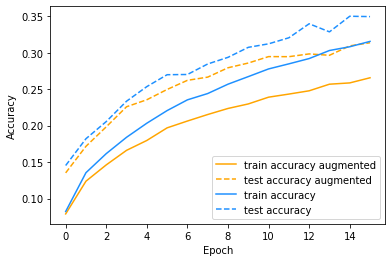

In [61]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(history_no_aug.history['accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(history_no_aug.history['val_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Model Evaluation

Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

Train Data Accuracy : 33%
Validation Data Loss : 3.2

Validation Data Accuracy : 35%
Validation Data Loss : 3.09

In [62]:
y_pred = m_no_aug.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Confusion Matrix

In [63]:
print(confusion_matrix(y_test_temp, y_pred))

[[63  2  0 ...  0  1  0]
 [ 1 42  0 ...  0  0  0]
 [ 4  1 24 ...  0  4  0]
 ...
 [ 0  0  1 ... 33  0  0]
 [ 2  0  4 ...  1 12  1]
 [ 3  0  2 ...  0  0 20]]


### Classification Report

In [64]:
print(classification_report(y_test_temp, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.63      0.57       100
           1       0.46      0.42      0.44       100
           2       0.24      0.24      0.24       100
           3       0.21      0.08      0.12       100
           4       0.22      0.12      0.16       100
           5       0.21      0.23      0.22       100
           6       0.31      0.27      0.29       100
           7       0.40      0.29      0.34       100
           8       0.43      0.39      0.41       100
           9       0.51      0.50      0.51       100
          10       0.30      0.17      0.22       100
          11       0.27      0.17      0.21       100
          12       0.39      0.39      0.39       100
          13       0.42      0.30      0.35       100
          14       0.26      0.23      0.25       100
          15       0.30      0.19      0.23       100
          16       0.54      0.31      0.39       100
          17       0.47    

Best Performing Class : Class 56

Worst Performing Class : Class 93

In [65]:
temp = {}

counter = 0
for t, p in zip(y_test_temp.flatten(), y_pred):
  if t != p:
    if t in temp:
      if len(temp[t]) < 2:
        temp[t].append(counter)
    else:
      temp[t] = [counter]
  counter +=1


In [66]:
sample_indexes = []
for _, y in temp.items():
  for x in y:
    sample_indexes.append(x)

## Wrong Predictions

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


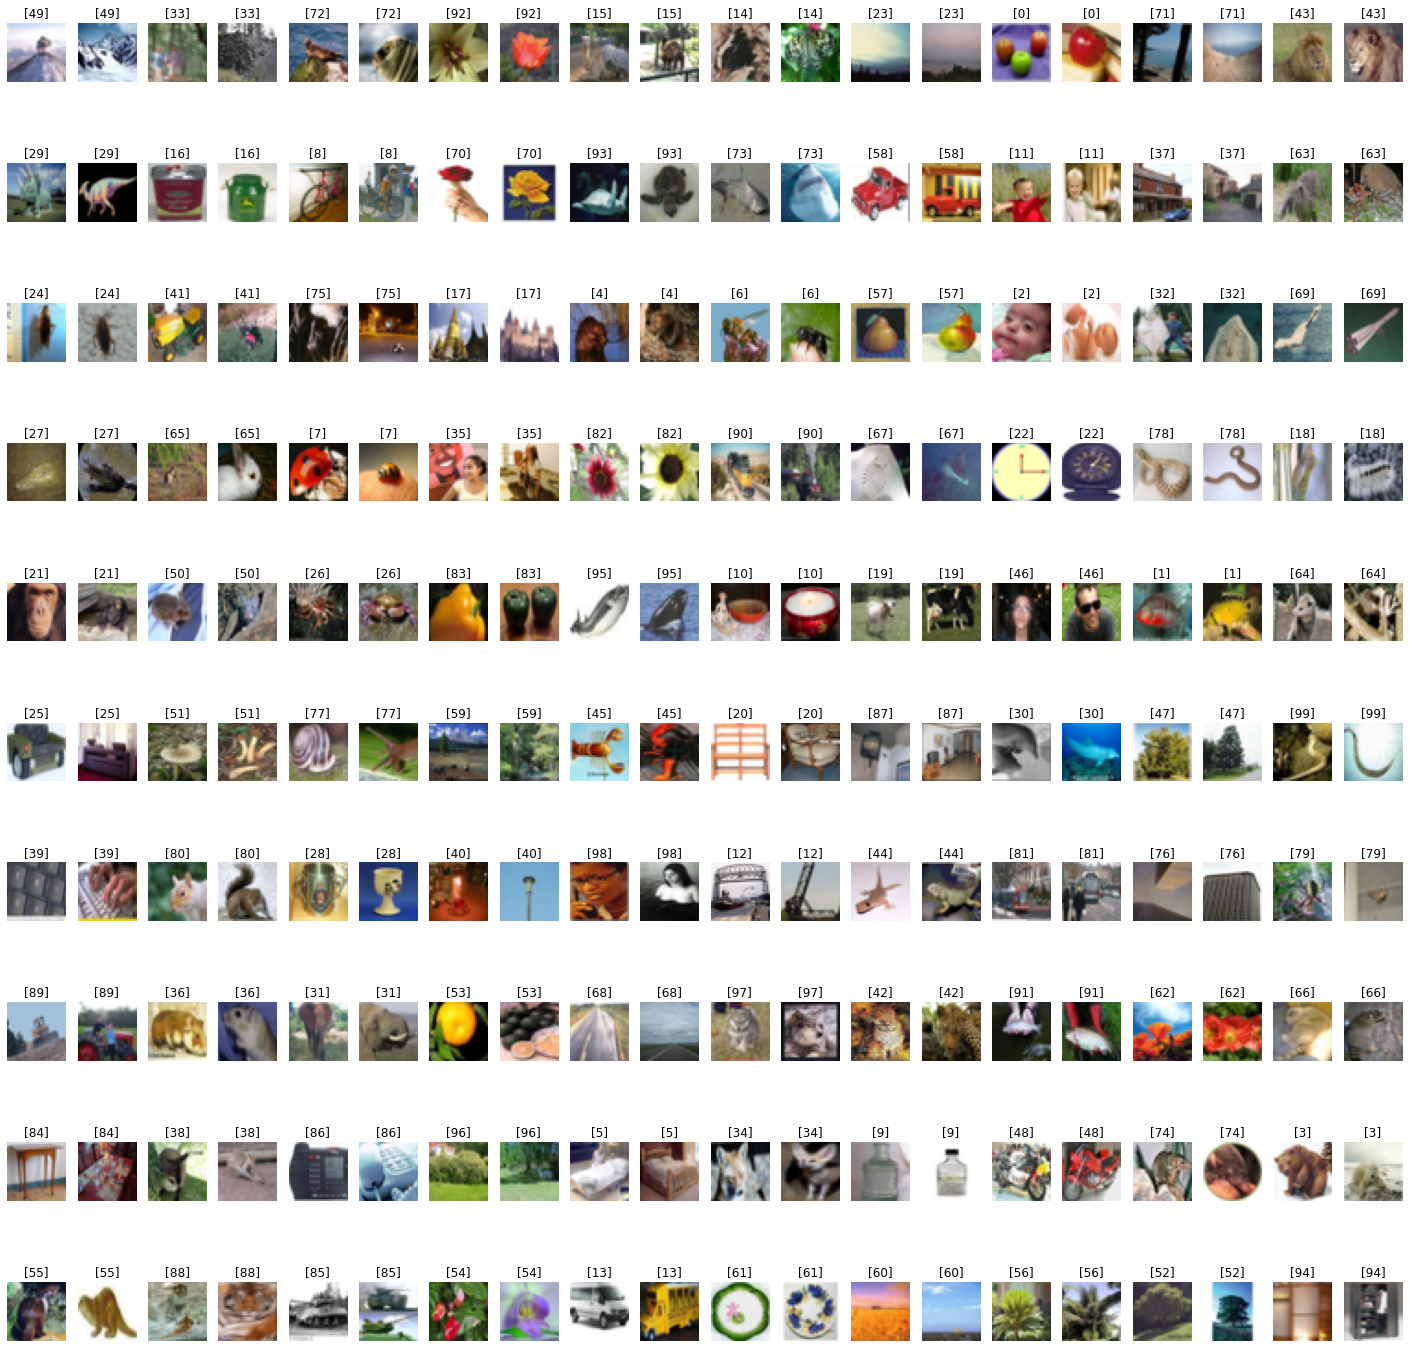

In [67]:
W_grid = 20
L_grid = 10

fig,axis = plt.subplots(L_grid, W_grid,figsize = (25,25))
axis = axis.ravel()  

for i,index in zip(np.arange(0, L_grid * W_grid),sample_indexes):
    axis[i].imshow(x_test[index])
    axis[i].set_title(y_test_temp[index])
    axis[i].axis('off')  
plt.subplots_adjust(hspace= 0.4)